In [66]:
import datasets
from torchsummary import summary
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
"""

lazwRow? 
custom collaborate function

"""

data = datasets.load_dataset('fashion_mnist')
batch_size = 1


train = data['train'].select(range(100))
test = data['test']


data_transform=  transforms.Compose([
    #transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x/255.0)

])
def custom_collate_fn(batch):
    images = [data_transform(x['image']) for x in batch]
    labels = torch.tensor([x['label'] for x in batch])
    return torch.stack(images).cuda(), labels.cuda()

train_loader = DataLoader(train,batch_size,True,collate_fn=custom_collate_fn)





In [67]:
from torch.nn import Conv2d,ReLU,Linear,ConvTranspose2d,LeakyReLU,Tanh,Flatten,Unflatten,Sigmoid

mse = torch.nn.MSELoss()
lr = 1e-3
f=128
pad=1
encoder_decoder = torch.nn.Sequential(
    Conv2d(1,f,3,2,pad),
    ReLU(),
    Conv2d(f,2*f,3,2,pad),
    ReLU(),
    Flatten(),
    Linear(2*f*7*7,100),
    Linear(100,2*f*7*7),
    Unflatten(1,(2*f,7,7)),

    ConvTranspose2d(2*f,f,3,2,pad,1),
    ReLU(),
    ConvTranspose2d(f,1,3,2,pad,1),
    #Sigmoid()
    #Tanh()

).cuda()
summary(encoder_decoder,(1,28,28),device="cuda")
optim = torch.optim.Adam(encoder_decoder.parameters(),lr)

def step(x,y)->torch.Tensor:
    optim.zero_grad()
    output = encoder_decoder.forward(x)
    loss = mse(output,y)
    loss.backward()
    optim.step()
    return loss
    pass

train_loss = []
for epoch in range(200):
    for image,label in train_loader:
        #print(image.shape)
        #print(label.shape)
        #noise = torch.normal(0,1,size=(image.shape[0],1,28,28)).cuda()
        loss = step(image,image)
        #print(loss)
        train_loss.append(loss.cpu().detach().numpy())
        #break
        pass
    print(train_loss[-1])

plt.plot(train_loss)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           1,280
              ReLU-2          [-1, 128, 14, 14]               0
            Conv2d-3            [-1, 256, 7, 7]         295,168
              ReLU-4            [-1, 256, 7, 7]               0
           Flatten-5                [-1, 12544]               0
            Linear-6                  [-1, 100]       1,254,500
            Linear-7                [-1, 12544]       1,266,944
         Unflatten-8            [-1, 256, 7, 7]               0
   ConvTranspose2d-9          [-1, 128, 14, 14]         295,040
             ReLU-10          [-1, 128, 14, 14]               0
  ConvTranspose2d-11            [-1, 1, 28, 28]           1,153
Total params: 3,114,085
Trainable params: 3,114,085
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

KeyboardInterrupt: 

RuntimeError: DataLoader worker (pid(s) 15812, 820) exited unexpectedly

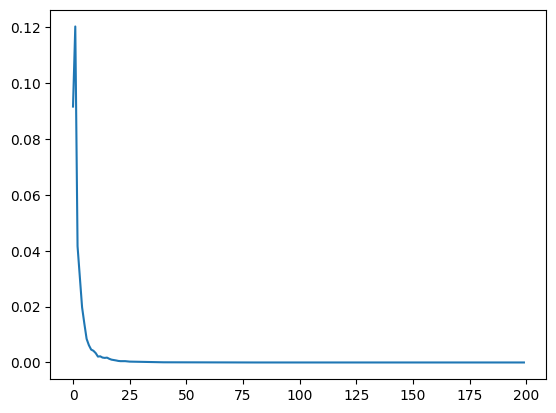

In [59]:
plt.plot(train_loss)

def show_preds(input,image=None):
    preds = input
    if image==None:
        preds:torch.Tensor= encoder_decoder(input)
        preds =  preds.moveaxis(1,-1)
        print(preds.shape)
        preds=preds.cpu().detach().numpy() 
    plt.figure(figsize=(1,1))
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10, 4))
    axs = axs.flatten()

    for i in range(preds.shape[0]):
        ax = axs[i]
        ax.imshow(preds[i],cmap='gray',interpolation='none')
        ax.axis('off')
    plt.show()

#noise = torch.normal(0,1,size=(12,1,28,28)).cuda()
#show_preds(noise)

for image,label in train_loader:
    show_preds(image[:12])
    show_preds(image[:12].cpu().moveaxis(1,-1),True)
    break
